# Rede Neural Convolucional com Dataset CIFAR-10

Grupo: Lucas Eduardo, Ian Marcony, Paulo Ricardo, Gustavo Araújo, Marcos Costa, Miguel Ângelo, Valéria Ribeiro, Kaique Olegar.

### CIFAR 10
O CIFAR-10 é um conjunto de dados de classificação de imagens que consiste em 60.000 imagens coloridas divididas em 10 classes. Cada imagem tem uma resolução de 32x32 pixels.
O dataset é dividido em um conjunto de treino com 50.000 imagens e um conjunto de teste com 10.000 imagens.
O problema proposto pelo CIFAR-10 é uma tarefa de classificação de imagens. O objetivo é treinar um modelo que possa identificar corretamente a classe de uma imagem entre as 10 possíveis. Isso envolve várias etapas:
1) Pré-processamento das Imagens
2) Normalização: Ajustar os valores dos pixels para uma faixa adequada (geralmente 0 a 1).
3) Augmentação de Dados: Aplicar técnicas como rotação, corte, e espelhamento para aumentar a variedade das imagens de treino e melhorar a generalização do modelo.
4) Construção do Modelo:Utilização de redes neurais convolucionais (CNNs), que são particularmente eficazes para tarefas de visão computacional devido à sua capacidade de capturar características espaciais e hierárquicas das imagens.
5) Treinamento: Ajuste dos pesos do modelo utilizando algoritmos de otimização (como SGD, Adam) para minimizar a função de perda, geralmente a entropia cruzada para problemas de classificação.
6) Avaliação:  Medir a precisão do modelo no conjunto de teste para verificar sua capacidade de generalização.

## Importação de bibliotecas necessárias

In [ ]:
!pip install keras

In [ ]:
!pip install h5py
!pip install typing-extensions
!pip install wheel

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
!pip install keras_cv

In [ ]:
!pip install scikeras

In [ ]:
!pip install scikit-learn==1.2.2

In [7]:
#Importando libs essenciais
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from keras.layers import BatchNormalization
from keras.layers  import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scikeras.wrappers import KerasClassifier
from keras_cv.layers import Grayscale
from prettytable import PrettyTable

2024-07-29 09:30:02.100975: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 09:30:02.103047: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-29 09:30:02.111741: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-29 09:30:02.141228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 09:30:02.188838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

## Separando dados para treinamentos

De início, é realizada a separação de dados de treinamento. 

### Leitura de dataset

In [8]:
#Separando dados para treinamentos
seed = 10
np.random.seed(seed)
(X_treinamento, y_treinamento),(X_teste, y_teste) =  cifar10.load_data()

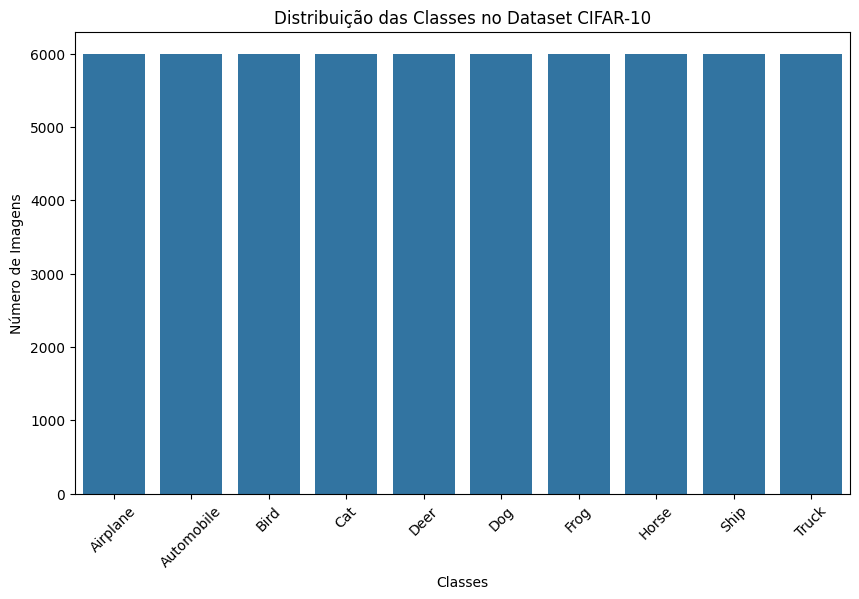

Airplane: 6000 imagens
Automobile: 6000 imagens
Bird: 6000 imagens
Cat: 6000 imagens
Deer: 6000 imagens
Dog: 6000 imagens
Frog: 6000 imagens
Horse: 6000 imagens
Ship: 6000 imagens
Truck: 6000 imagens


In [74]:
import seaborn as sns

y_total = np.concatenate((y_treinamento, y_teste), axis=0)

# Contando o número de exemplos em cada classe
unique, counts = np.unique(y_total, return_counts=True)
class_counts = dict(zip(unique, counts))

# Classes em CIFAR-10
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Mapeando índices para nomes de classes
class_counts_named = {class_names[i]: count for i, count in class_counts.items()}

# Plotando a distribuição das classes
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts_named.keys()), y=list(class_counts_named.values()))
plt.title('Distribuição das Classes no Dataset CIFAR-10')
plt.xlabel('Classes')
plt.ylabel('Número de Imagens')
plt.xticks(rotation=45)
plt.show()

# Imprimindo a distribuição das classes
for class_name, count in class_counts_named.items():
    print(f'{class_name}: {count} imagens')

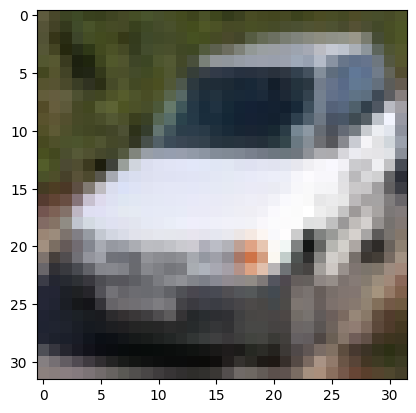

In [8]:
#Mostrando imagem
plt.imshow(X_treinamento[46])

### Conversão das imagens em escala de cinza

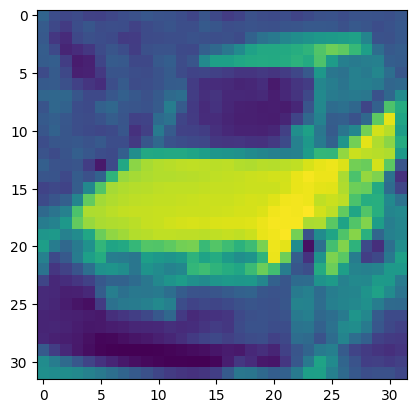

In [9]:
# Convertendo imagens
to_grayscale = Grayscale()
previsores_treinamento = to_grayscale(X_treinamento)
previsores_teste = to_grayscale(X_teste)
previsores_treinamento = np.array(previsores_treinamento)
previsores_teste = np.array(previsores_teste)
plt.imshow(previsores_treinamento[46])

In [10]:
print(previsores_treinamento.shape)
print(previsores_teste.shape)

(50000, 32, 32, 1)
(10000, 32, 32, 1)


### Tratando dados de pixels para uma escala de 0-1

In [10]:
#Tratando dados de pixels para uma escala de 0-1
previsores_treinamento /= 255
previsores_teste /= 255

### Convertendo classes

In [11]:
#Convertendo classes
classe_treinamento = to_categorical(y_treinamento, 10)
classe_teste = to_categorical(y_teste, 10)

## Criação de Augumentation

In [12]:
# Augumentation
gerador_treinamento = ImageDataGenerator(rotation_range=7,
                                         horizontal_flip= True,
                                         shear_range = 0.2,
                                         height_shift_range = 0.07,
                                         zoom_range=0.2)

gerador_teste = ImageDataGenerator()

base_treinamento = gerador_treinamento.flow(previsores_treinamento, classe_treinamento, batch_size= 128)
base_teste = gerador_teste.flow(previsores_teste, classe_teste, batch_size= 128)

In [14]:
print(base_treinamento.x.shape)
print(base_teste.x.shape)
print(classe_treinamento.shape)
print(classe_teste.shape)
print(previsores_treinamento.shape)
print(previsores_teste.shape)

(50000, 32, 32, 1)
(10000, 32, 32, 1)
(50000, 10)
(10000, 10)
(50000, 32, 32, 1)
(10000, 32, 32, 1)


## Criação da Rede Neural Convolucional

In [13]:
#Iniciar rede convulacional
def criarRede(optimizer='adam', activation='relu', learning_rate=0.001):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam, RMSprop
    
    classificador = Sequential()
    classificador.add(Conv2D(32, (4,4), input_shape=(32,32,1), activation=activation))
    classificador.add(BatchNormalization())
    classificador.add(MaxPooling2D(pool_size=(2,2)))
    classificador.add(Conv2D(32, (3,3), strides=2, activation=activation))
    classificador.add(BatchNormalization())
    classificador.add(MaxPooling2D(pool_size=(2,2)))
    classificador.add(Flatten())
    classificador.add(Dense(units=128, activation=activation))
    classificador.add(Dropout(0.2))
    classificador.add(Dense(units=256, activation=activation))
    classificador.add(Dropout(0.2))
    classificador.add(Dense(units=10, activation='softmax'))
    
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    
    classificador.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return classificador

In [36]:
# Labels do CIFAR 10
labels = 'airplane automobile bird cat deer dog frog horse ship truck'.upper().split(' ')
labels

['AIRPLANE',
 'AUTOMOBILE',
 'BIRD',
 'CAT',
 'DEER',
 'DOG',
 'FROG',
 'HORSE',
 'SHIP',
 'TRUCK']

## Inicialização de treinamentos e testes

### Instanciando rede neural

In [16]:
classificador = criarRede()

/home/dialog/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Usando dados originais em escala de cinza

In [ ]:
# Usando dados originais em escala de cinza
classificador.fit(previsores_treinamento, classe_treinamento, batch_size= 128, epochs = 20)
precisao = classificador.evaluate(previsores_teste, classe_teste)
print(f'Precisão usando dados originais em escala de cinza: {precisao}')

Epoch 1/20
391/391 [==============================] - 9s 6ms/step - loss: 1.7199 - accuracy: 0.3826
Epoch 2/20
391/391 [==============================] - 2s 5ms/step - loss: 1.3709 - accuracy: 0.5154
Epoch 3/20
391/391 [==============================] - 2s 5ms/step - loss: 1.2174 - accuracy: 0.5730
Epoch 4/20
391/391 [==============================] - 2s 5ms/step - loss: 1.1190 - accuracy: 0.6077
Epoch 5/20
391/391 [==============================] - 2s 6ms/step - loss: 1.0453 - accuracy: 0.6362
Epoch 6/20
391/391 [==============================] - 2s 6ms/step - loss: 0.9917 - accuracy: 0.6528
Epoch 7/20
391/391 [==============================] - 2s 5ms/step - loss: 0.9449 - accuracy: 0.6695
Epoch 8/20
391/391 [==============================] - 2s 5ms/step - loss: 0.9098 - accuracy: 0.6829
Epoch 9/20
391/391 [==============================] - 2s 5ms/step - loss: 0.8708 - accuracy: 0.6939
Epoch 10/20
391/391 [==============================] - 2s 5ms/step - loss: 0.8435 - accuracy: 0.7051

1/1 [==============================] - 0s 194ms/step
Previsão: 0 Label Prevista: AIRPLANE
Classe real: 0 Label Real: AIRPLANE
Resultado: ACERTOU


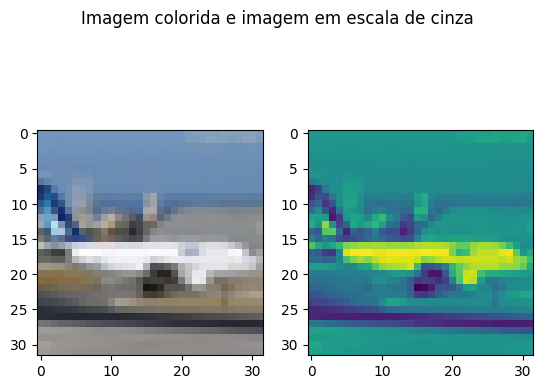

In [ ]:
index =  90
imagem_teste = np.expand_dims(previsores_teste[index], axis =0)
previsao = classificador.predict(imagem_teste)
previsao = np.argmax(previsao, axis=-1)[0]
classe_real = preds_classes = np.argmax(classe_teste[index], axis=-1)
fig, axs = plt.subplots(1,2)
fig.suptitle('Imagem colorida e imagem em escala de cinza')
axs[0].imshow(X_teste[index])
axs[1].imshow(previsores_teste[index])
resultado = 'ACERTOU' if previsao==classe_real else 'ERROU'
print(f'Previsão: {previsao} Label Prevista: {labels[previsao]}\nClasse real: {classe_real} Label Real: {labels[classe_real]}\nResultado: {resultado}')

### Validação Cruzada

In [24]:
previsores = np.concatenate((previsores_treinamento, previsores_teste))
classes = np.concatenate((classe_treinamento, classe_teste))

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

precisoes = []
recalls = []
acuracias = []

for k, (train_index, test_index) in enumerate(kfold.split(previsores, np.argmax(classes, axis=1))):
    print("=-"*6 + f"Fold: {k+1}" + "-="*6)
    X_train, X_val = previsores[train_index], previsores[test_index]
    y_train, y_val = classes[train_index], classes[test_index]

    classificador = criarRede()
    classificador.fit(gerador_treinamento.flow(X_train, y_train, batch_size=128),
                      epochs=15, validation_data=(X_val, y_val), verbose=0)

    y_pred = classificador.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_val_classes = np.argmax(y_val, axis=1)

    precisao = precision_score(y_val_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_val_classes, y_pred_classes, average='weighted')
    acuracia = accuracy_score(y_val_classes, y_pred_classes)

    precisoes.append(precisao)
    recalls.append(recall)
    acuracias.append(acuracia)

print("Resultados da Validação Cruzada:")
print("Precisões:", precisoes)
print("Recalls:", recalls)
print("Acurácias:", acuracias)
print("Média da Precisão:", np.mean(precisoes))
print("Média de Recalls:", np.mean(recalls))
print("Média da Acurácia:", np.mean(acuracias))

=-=-=-=-=-=-Fold: 1-=-=-=-=-=-=


/home/dialog/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/dialog/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=-=-=-=-=-=-Fold: 2-=-=-=-=-=-=


/home/dialog/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/dialog/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=-=-=-=-=-=-Fold: 3-=-=-=-=-=-=


/home/dialog/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/dialog/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=-=-=-=-=-=-Fold: 4-=-=-=-=-=-=


/home/dialog/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/dialog/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=-=-=-=-=-=-Fold: 5-=-=-=-=-=-=


/home/dialog/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/dialog/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Resultados da Validação Cruzada:
Precisões: [0.636938885819176, 0.6680666564450526, 0.6155609821671608, 0.6607229008718294, 0.6569730866194988]
Recalls: [0.5725833333333333, 0.66075, 0.52525, 0.6555, 0.65]
Acurácias: [0.5725833333333333, 0.66075, 0.52525, 0.6555, 0.65]
Média da Precisão: 0.6476525023845435
Média de Recalls: 0.6128166666666666
Média da Acurácia: 0.6128166666666666


In [ ]:
resultados =  np.array(resultados)
mediaCross  = resultados.mean()
print(mediaCross)

0.7645600020885468


1/1 [==============================] - 0s 146ms/step
Previsão: 6 Label Prevista: FROG
Classe real: 6 Label Real: FROG
Resultado: ACERTOU


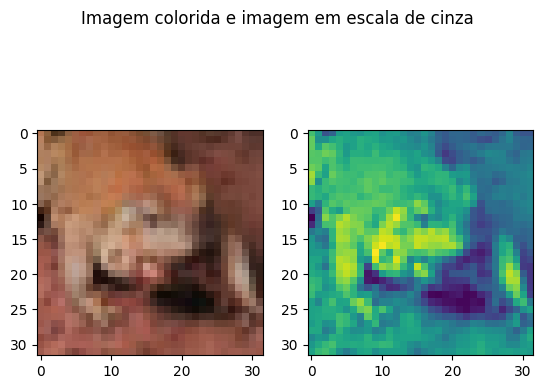

In [ ]:
index =  5
imagem_teste = np.expand_dims(previsores_teste[index], axis =0)
previsao = classificador.predict(imagem_teste)
previsao = np.argmax(previsao, axis=-1)[0]
classe_real = preds_classes = np.argmax(classe_teste[index], axis=-1)
fig, axs = plt.subplots(1,2)
fig.suptitle('Imagem colorida e imagem em escala de cinza')
axs[0].imshow(X_teste[index])
axs[1].imshow(previsores_teste[index])
resultado = 'ACERTOU' if previsao==classe_real else 'ERROU'
print(f'Previsão: {previsao} Label Prevista: {labels[previsao]}\nClasse real: {classe_real} Label Real: {labels[classe_real]}\nResultado: {resultado}')

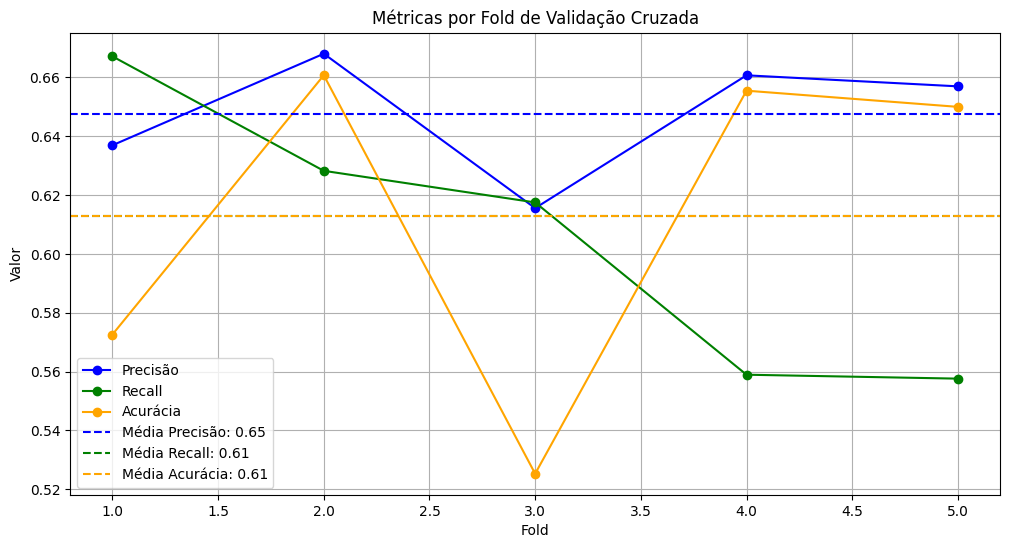

In [25]:
plt.figure(figsize=(12, 6))
folds = range(1, len(precisoes) + 1)

plt.plot(folds, precisoes, marker='o', linestyle='-', color='blue', label='Precisão')
plt.plot(folds, revocacoes, marker='o', linestyle='-', color='green', label='Recall')
plt.plot(folds, acuracias, marker='o', linestyle='-', color='orange', label='Acurácia')

# Adicionar linhas horizontais para médias
plt.axhline(y=np.mean(precisoes), color='blue', linestyle='--', label=f'Média Precisão: {np.mean(precisoes):.2f}')
plt.axhline(y=np.mean(recalls), color='green', linestyle='--', label=f'Média Recall: {np.mean(recalls):.2f}')
plt.axhline(y=np.mean(acuracias), color='orange', linestyle='--', label=f'Média Acurácia: {np.mean(acuracias):.2f}')

plt.xlabel('Fold')
plt.ylabel('Valor')
plt.title('Métricas por Fold de Validação Cruzada')
plt.legend()
plt.grid(True)

plt.show()

### Treinamento e teste com Augumentation

In [ ]:
classificador = criarRede()
classificador.fit(base_treinamento,
                  steps_per_epoch= base_treinamento.x.shape[0]/base_treinamento.batch_size,
                  epochs = 20,
                  validation_data=base_teste,
                  validation_steps=base_teste.x.shape[0]/base_teste.batch_size)
precisao = classificador.evaluate(base_teste.x, base_teste.y)
print(f'Precisão usando dados originais em escala de cinza: {precisao}')

Epoch 1/20
390/390 [==============================] - 19s 42ms/step - loss: 1.8011 - accuracy: 0.3533 - val_loss: 2.2139 - val_accuracy: 0.2419
Epoch 2/20
390/390 [==============================] - 16s 42ms/step - loss: 1.5303 - accuracy: 0.4591 - val_loss: 1.7576 - val_accuracy: 0.3992
Epoch 3/20
390/390 [==============================] - 17s 45ms/step - loss: 1.4069 - accuracy: 0.5055 - val_loss: 1.4803 - val_accuracy: 0.4793
Epoch 4/20
390/390 [==============================] - 16s 41ms/step - loss: 1.3266 - accuracy: 0.5344 - val_loss: 1.6548 - val_accuracy: 0.4549
Epoch 5/20
390/390 [==============================] - 16s 41ms/step - loss: 1.2622 - accuracy: 0.5611 - val_loss: 1.1611 - val_accuracy: 0.5963
Epoch 6/20
390/390 [==============================] - 16s 42ms/step - loss: 1.2104 - accuracy: 0.5742 - val_loss: 1.1096 - val_accuracy: 0.6131
Epoch 7/20
390/390 [==============================] - 18s 46ms/step - loss: 1.1761 - accuracy: 0.5893 - val_loss: 1.4411 - val_accuracy:

1/1 [==============================] - 0s 18ms/step
Previsão: 9 Label Prevista: TRUCK
Classe real: 9 Label Real: TRUCK
Resultado: ACERTOU


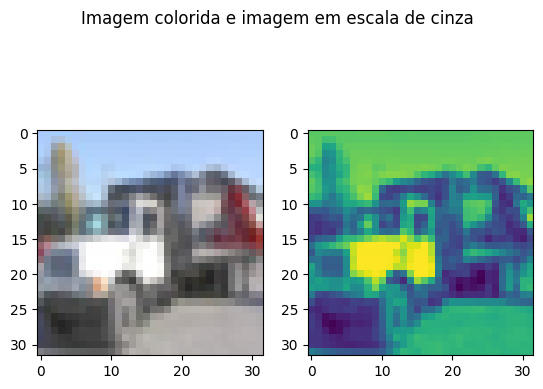

In [ ]:
index =  45
imagem_teste = np.expand_dims(previsores_teste[index], axis =0)
previsao = classificador.predict(imagem_teste)
previsao = np.argmax(previsao, axis=-1)[0]
classe_real = preds_classes = np.argmax(classe_teste[index], axis=-1)
fig, axs = plt.subplots(1,2)
fig.suptitle('Imagem colorida e imagem em escala de cinza')
axs[0].imshow(X_teste[index])
axs[1].imshow(previsores_teste[index])
resultado = 'ACERTOU' if previsao==classe_real else 'ERROU'
print(f'Previsão: {previsao} Label Prevista: {labels[previsao]}\nClasse real: {classe_real} Label Real: {labels[classe_real]}\nResultado: {resultado}')

# Busca em grade

Para observar as métricas de diferentes combinações de hiperparâmetros aplicados em um modelo, foi utilizada a busca em grade. Trata-se de uma técnica para encontrar os melhores hiperparâmetros para um modelo de aprendizado de máquina. Foram testados o seguintes parâmetros:
1) Otimizador: 
2) Número de Épocas: O número de vezes que o modelo vê todo o conjunto de dados durante o treinamento.
3) Learnig rate
4) FUnção de ati

O método grid.fit() utiliza a técnica de validação cruzada para avaliar o desempenho do modelo com diferentes combinações de hiperparâmetros. Durante a validação cruzada, os dados são divididos em várias partes (folds), e o treinamento é realizado várias vezes, cada vez usando uma parte diferente dos dados como conjunto de validação e o restante como conjunto de treinamento.

In [14]:
# Parâmetros escolhidos para ajustar
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [10, 15],
    'learning_rate': [0.001, 0.01],
    'activation': ['relu', 'tanh','sigmoid']
}

In [15]:
# !pip install scikeras
import scikeras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold

In [16]:
previsores = np.concatenate((previsores_treinamento, previsores_teste))
classes = np.concatenate((classe_treinamento, classe_teste))

# Create KerasClassifier with the wrapper build_fn
classificador = KerasClassifier(build_fn=criarRede, verbose=0, activation = 'relu', learning_rate=0.001)

# Set up KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# Configure GridSearchCV
grid = GridSearchCV(estimator=classificador, param_grid=param_grid, scoring='accuracy', cv=kfold)

# Fit the model
grid_result = grid.fit(previsores, classes)

/home/dialog/.local/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/dialog/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/dialog/.local/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/dialog/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` 

In [46]:
# Exibir melhores parâmetros e resultados
print(f'Melhores parâmetros: {grid_result.best_params_}')
print("Melhor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))

Melhores parâmetros: {'activation': 'relu', 'epochs': 15, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}
Melhor: 0.650200 usando {'activation': 'relu', 'epochs': 15, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}


In [47]:
# Média dos resultados
media = means.mean()
std = stds.mean()

In [71]:
table = PrettyTable()
table.field_names = ["Melhor da Acurácia", "Desvio Padrão", "Função de Ativação", "Épocas","Taxa de aprendizado","Otimizador"]

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

combined_results = [
    (mean, std, param['activation'], param['epochs'], param['learning_rate'], param.get('optimizer', 'default_optimizer'))
    for mean, std, param in zip(means, stds, params)
]

sorted_results = sorted(combined_results, key=lambda x: x[0], reverse=True)

for result in sorted_results:
    table.add_row([f"{result[0]:.4f}", f"{result[1]:.4f}", result[2], result[3], result[4], result[5]])

print(table)

+--------------------+--------------------+--------+---------------------+------------+
| Melhor da Acurácia | Função de Ativação | Épocas | Taxa de aprendizado | Otimizador |
+--------------------+--------------------+--------+---------------------+------------+
|       0.6502       |        relu        |   15   |        0.001        |  rmsprop   |
|       0.6131       |      sigmoid       |   15   |        0.001        |    adam    |
|       0.6105       |        relu        |   15   |        0.001        |    adam    |
|       0.6080       |        relu        |   10   |        0.001        |    adam    |
|       0.6073       |      sigmoid       |   15   |        0.001        |  rmsprop   |
|       0.6045       |      sigmoid       |   10   |        0.001        |  rmsprop   |
|       0.6012       |        relu        |   10   |        0.001        |  rmsprop   |
|       0.5706       |        tanh        |   15   |        0.001        |    adam    |
|       0.5659       |        ta

<Figure size 1400x700 with 0 Axes>

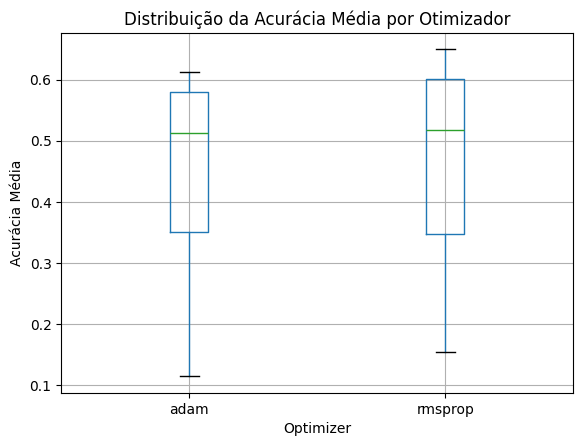

In [23]:
import pandas as pd
results = pd.DataFrame(grid_result.cv_results_)

# Boxplot para Distribuição das Métricas
plt.figure(figsize=(14, 7))
results.boxplot(column='mean_test_score', by='param_optimizer', grid=True)
plt.xlabel('Optimizer')
plt.ylabel('Acurácia Média')
plt.title('Distribuição da Acurácia Média por Otimizador')
plt.suptitle('')  # Remove the default title
plt.show()


In [52]:
#Treinando um modelo com base nos resultados obtidos no grid
classificador_grid = criarRede()
classificador_grid.fit(previsores_treinamento, classe_treinamento, batch_size= 32, epochs = 15)
precisao = classificador_grid.evaluate(previsores_teste, classe_teste)
imagem_teste = np.expand_dims(previsores_teste[index], axis =0)
previsao_grid = classificador.predict(imagem_teste)
previsao_grid = np.argmax(previsao_grid, axis=-1)[0]
classe_real = preds_classes = np.argmax(classe_teste[index], axis=-1)

Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 20ms/step - accuracy: 0.3424 - loss: 1.8284
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.5338 - loss: 1.3314
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.5933 - loss: 1.1693
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.6227 - loss: 1.0838
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.6469 - loss: 1.0177
Epoch 6/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.6635 - loss: 0.9592
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.6761 - loss: 0.9246
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.6846 - loss: 0.8944
Epoch 9/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.7002 - loss: 0.8517
Epoch 10/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.7102 - loss: 0.8275
Epoch 11/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.7132 - loss: 0.8149
Epoch 12

Previsão: 7 Label Prevista: HORSE
Classe real: 7 Label Real: HORSE
Resultado: ACERTOU


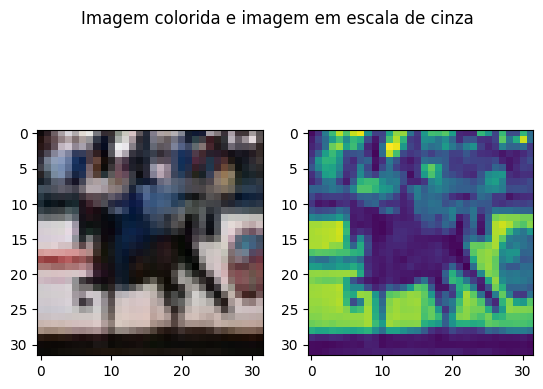

In [53]:
index = 203
fig, axs = plt.subplots(1,2)
fig.suptitle('Imagem colorida e imagem em escala de cinza')
axs[0].imshow(X_teste[index])
axs[1].imshow(previsores_teste[index])
resultado = 'ACERTOU' if previsao_grid==classe_real else 'ERROU'
print(f'Previsão: {previsao_grid} Label Prevista: {labels[previsao_grid]}\nClasse real: {classe_real} Label Real: {labels[classe_real]}\nResultado: {resultado}')

# Avaliação dos Resultados do Notebook

Com base nos resultados obtidos acerca do desempenho do modelo em relação à métrica escolhida (no caso, acuŕacia) e da rede neural, podemos sumarizar os testes em:

1) Busca em grade com K-fold com K = 5:
   - Melhores parâmetros: {'activation': 'relu', 'epochs': 15, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}
   - Melhor Acurácia: 0.650200 usando {'activation': 'relu', 'epochs': 15, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}

-------------------------     

2) Treinamento e teste sem Augumentation com Holdout com 20 épocas:
    - Dados originais em escala de cinza.
    - Função de ativação: relu; Otimizador: Adam, Taxa de aprendizado: 0.001
    - Acurácias por épocas: 0.3826, 0.5154, 0.5730, 0.6077, 0.6362, 0.6528, 0.6695, 0.6829, 0.6939, 0.7051, 0.7119, 0.7218, 0.7276, 0.7335, 0.7378, 0.7421, 0.7511, 0.7519, 0.7578, 0.7610, 0.6462
    - Melhor Acurácia: 0.7610
-------------------------

3) Treinamento e teste com Augumentation com 20 épocas:
    - Função de ativação: relu; Otimizador: Adam, Taxa de aprendizado: 0.001
    - Acuŕacias por época: 0.4591, 0.5055, 0.5344, 0.5611, 0.5742, 0.5893, 0.5994, 0.6088, 0.6170, 0.6256, 0.6315, 0.6368, 0.6385, 0.6453, 0.6475, 0.6514, 0.6540, 0.6566, 0.6613, 0.6437
    - Melhor acurácia: 0.6613
-------------------------
   
5) Treinamento e teste sem Augumentation com K-Fold com k = 5 e 20 Épocas:
    - Função de ativação: relu; Otimizador: Adam, Taxa de aprendizado: 0.001
    - Acurácias por fold: 0.5725833333333333, 0.66075, 0.52525, 0.6555, 0.65
    - Melhor acurácia: 0.66075
-------------------------

Portanto, a partir das acurácias listadas acima, nota-se que o modelo com melhor resultado foi obtido no treinamento e teste da rede neural sem Data Augumentation, com dados originais em escala cinza e com o Holdout padrão do dataset (50 mil imagens para 10 mil imagens para teste).
   

In [56]:
from prettytable import PrettyTable

# Criar a tabela
table = PrettyTable()

# Definir o cabeçalho da tabela
table.field_names = ["Tipo de Treinamento", "Função de Ativação", "Número de Épocas", "Taxa de Aprendizado", "Otimizador", "Melhor Acurácia"]

# Adicionar as linhas da tabela com base nos dados fornecidos
table.add_row([
    "Busca em grade com K-fold (K=5)",
    "relu",
    15,
    0.001,
    "rmsprop",
    0.650200
])

table.add_row([
    "Sem Augmentation com Holdout",
    "relu",
    20,
    0.001,
    "Adam",
    0.7610
])

table.add_row([
    "Sem Augmentation com K-Fold (K=5)",
    "relu",
    20,
    0.001,
    "Adam",
    0.66075
])

table.add_row([
    "Com Augmentation",
    "relu",
    20,
    0.001,
    "Adam",
    0.6613
])


# Exibir a tabela
print(table)


+-----------------------------------+--------------------+------------------+---------------------+------------+-----------------+
|        Tipo de Treinamento        | Função de Ativação | Número de Épocas | Taxa de Aprendizado | Otimizador | Melhor Acurácia |
+-----------------------------------+--------------------+------------------+---------------------+------------+-----------------+
|  Busca em grade com K-fold (K=5)  |        relu        |        15        |        0.001        |  rmsprop   |      0.6502     |
|    Sem Augmentation com Holdout   |        relu        |        20        |        0.001        |    Adam    |      0.761      |
| Sem Augmentation com K-Fold (K=5) |        relu        |        20        |        0.001        |    Adam    |     0.66075     |
|          Com Augmentation         |        relu        |        20        |        0.001        |    Adam    |      0.6613     |
+-----------------------------------+--------------------+------------------+------

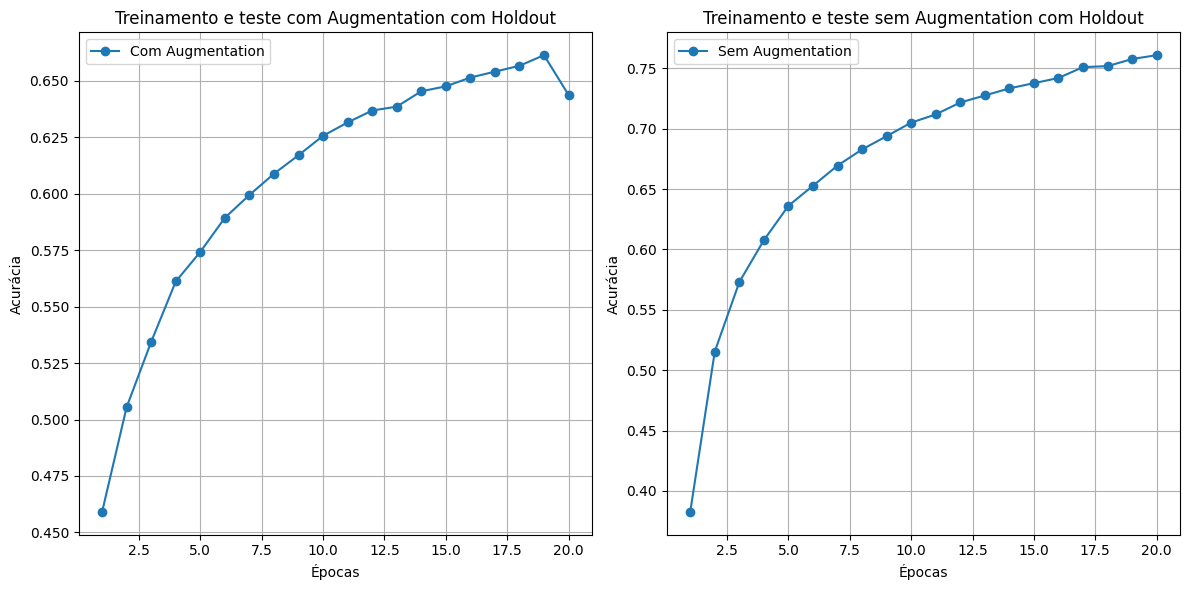

In [60]:
import matplotlib.pyplot as plt

# Dados de acurácia
accuracy_log1 = [0.4591, 0.5055, 0.5344, 0.5611, 0.5742, 0.5893, 0.5994, 0.6088, 0.6170, 0.6256, 0.6315, 0.6368, 0.6385, 0.6453, 0.6475, 0.6514, 0.6540, 0.6566, 0.6613, 0.6437]
accuracy_log2 = [0.3826, 0.5154, 0.5730, 0.6077, 0.6362, 0.6528, 0.6695, 0.6829, 0.6939, 0.7051, 0.7119, 0.7218, 0.7276, 0.7335, 0.7378, 0.7421, 0.7511, 0.7519, 0.7578, 0.7610]

# Épocas
epochs = list(range(1, 21))

# Gráfico 1: Treinamento e teste com Augmentation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy_log1, marker='o', label='Com Augmentation')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.title('Treinamento e teste com Augmentation com Holdout')
plt.legend()
plt.grid(True)

# Gráfico 2: Treinamento e teste sem Augmentation com Holdout
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_log2, marker='o', label='Sem Augmentation')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.title('Treinamento e teste sem Augmentation com Holdout')
plt.legend()
plt.grid(True)

# Exibir os gráficos
plt.tight_layout()
plt.show()
